In [2]:
import sys
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import glob
import os
import shutil

parent_dir = os.getcwd()

#### Convert Training Data to DataFrames for the Neural Network

In [9]:
training_path = os.path.join(parent_dir, "training_data")
training_files = glob.glob(training_path + "/*.csv")
data = []
for file in training_files:
    df = pd.read_csv(file, usecols = [i for i in range(1, 42)])
    df = df.drop(['team1', 'team1pts','team2', 'team2pts', '1GP', '2GP', '1W', '2W', '1L', '2L'], axis=1)
    df = df.drop(['1MIN', '2MIN','1AST/TO', '2AST/TO'], axis = 1)
    data.append(df)

training_data = pd.concat(data, axis=0, ignore_index=True)
print(training_data.head())

   1OffRtg  1DefRtg  1NetRtg  1AST%  1ASTRatio  1OREB%  1DREB%  1REB%  1TOV%  \
0    104.5     98.8      5.7   54.3       16.5    24.6    72.3   49.3   17.0   
1    109.0    104.1      4.9   59.9       17.4    37.6    69.1   53.5   17.4   
2    108.7     98.0     10.7   57.8       16.8    33.7    70.9   52.2   15.2   
3    107.6    115.4     -7.7   60.7       17.2    29.2    63.0   45.0   12.0   
4    101.5    105.9     -4.5   68.5       20.2    26.6    69.2   49.6   17.7   

   1eFG%  ...  2ASTRatio  2OREB%  2DREB%  2REB%  2TOV%  2eFG%  2TS%  2PACE  \
0   52.2  ...       16.8    24.4    76.1   47.5   15.1   46.7  52.3  97.38   
1   50.5  ...       17.0    36.0    69.2   53.8   17.1   48.5  52.4  89.90   
2   50.5  ...       15.9    25.2    66.8   49.0   19.5   53.4  59.2  94.80   
3   50.2  ...       15.5    30.4    71.6   51.0   15.5   45.1  48.8  93.63   
4   52.8  ...       15.9    34.5    65.3   50.0   16.8   48.6  52.4  90.20   

   2PIE  net  
0  45.4   11  
1  56.3    1  
2  55

#### Convert Validation Data to DataFrames for the Neural Network

In [4]:
test_path = os.path.join(parent_dir, "test_data")
test_files = glob.glob(test_path + "/*.csv")
data = []
for file in test_files:
    df = pd.read_csv(file, usecols = [i for i in range(1, 42)])
    df = df.drop(['team1', 'team1pts','team2', 'team2pts', '1GP', '2GP', '1W', '2W', '1L', '2L'], axis=1)
    df = df.drop(['1MIN', '2MIN','1AST/TO', '2AST/TO'], axis = 1)
    data.append(df)

test_data = pd.concat(data, axis=0, ignore_index=True)

#### Split the Features and the Labels 

In [5]:
training_features = training_data.copy()
training_labels = training_features.pop('net')

test_features = test_data.copy()
test_labels = test_features.pop('net')

print(training_features.to_numpy()[0])

[104.5   98.8    5.7   54.3   16.5   24.6   72.3   49.3   17.    52.2
  56.1  100.38  56.4   99.5  105.4   -5.9   66.2   16.8   24.4   76.1
  47.5   15.1   46.7   52.3   97.38  45.4 ]


## Neural Net Construction

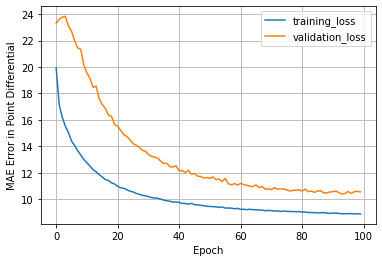

In [6]:
##Normalize Data
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(training_features))

model = tf.keras.Sequential()
model.add(normalizer)
model.add(layers.Dense(64, activation='sigmoid', activity_regularizer = tf.keras.regularizers.l1_l2(l1=0.2, l2=0.2)))
model.add(layers.Dense(64, activation='tanh', activity_regularizer = tf.keras.regularizers.l1_l2(l1=0.2, l2=0.2)))
model.add(layers.Dense(64, activation='relu', bias_regularizer = tf.keras.regularizers.l1_l2(l1=0.2, l2=0.2)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))
model.compile(loss = 'mean_absolute_error', optimizer='Adam')

history = model.fit(training_features, training_labels, epochs=100, verbose=0, validation_split=0.2)

plt.plot(history.history['loss'], label='training_loss')
plt.plot(history.history['val_loss'], label='validation_loss')
plt.xlabel('Epoch')
plt.ylabel('MAE Error in Point Differential')
plt.legend()
plt.grid(True)
plt.show()

## Neural Net Testing

Text(0.5, 1.0, 'Model Predicted vs Actual Point Differentials, where PD = Away Team - Home Team')

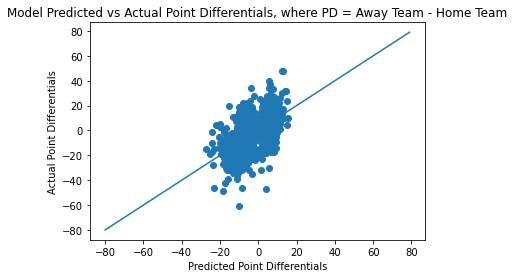

In [7]:
predictions = model.predict(test_features).flatten()
plt.scatter(predictions, test_labels)
x = range(-80, 80)
y = x
plt.plot(x, y)
plt.xlabel('Predicted Point Differentials')
plt.ylabel('Actual Point Differentials')
plt.title('Model Predicted vs Actual Point Differentials, where PD = Away Team - Home Team')

0.7130281690140845% accurate


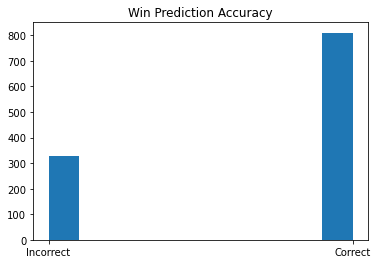

In [8]:
def sign(i):
    if i<0:
        return False
    if i>0:
        return True
    return True

r = len(test_labels)
p = list(predictions)
t = list(test_labels)
data = [sign(p[i])==sign(t[i]) for i in range(r)]
data = ['Correct' if i else 'Incorrect' for i in data]
plt.hist(data)
plt.title('Win Prediction Accuracy')
accuracy = data.count('Correct')/len(data)
print(str(accuracy) + '% accurate')

## Predictor

In [10]:
## Using the model to make predictions

# from selenium import webdriver
# from urllib.request import urlopen
# from bs4 import BeautifulSoup
# import re
# import sys
# import shutil
# import os
# import time

# # ENTER PARAMETERS
# playoffs = True
# team1 = 'Los Angeles Lakers'
# team2 = 'Miami Heat'


# parent_dir = os.getcwd()
# if playoffs:
#     url = 'https://stats.nba.com/teams/advanced/?sort=W&dir=-1&Season=2019-20&SeasonType=Playoffs&LastNGames=15'
# else:
#     url = 'https://stats.nba.com/teams/advanced/?sort=W&dir=-1&Season=2019-20&SeasonType=Regular&LastNGames=15'

# d = webdriver.Chrome(executable_path=parent_dir+'\chromedriver.exe')
# d.get(url)

# s = BeautifulSoup(d.page_source, 'html.parser').find('table')
# headers, [_, *data] = [i.getText().strip() for i in s.find_all('th')], [[i.getText().strip() for i in b.find_all('td')] for b in s.find_all('tr')]
# final_data = [i for i in data if len(i) > 1]
# print(final_data)
# df1 = pd.DataFrame(final_data, columns = headers[:21])
# del df1['']

# features = pd.DataFrame([(team1, team2)], columns = ['team1', 'team2'])

# features = features.merge(df1.add_prefix('1'), how='left', right_on = ['1TEAM'], left_on = ['team1']).drop(['1TEAM'], axis=1)
# features = features.merge(df1.add_prefix('2'), how='left', right_on = ['2TEAM'], left_on = ['team2']).drop(['2TEAM'], axis=1)

# ENTER TEAM 1 STATS IN THIS ORDER: OffRtg  DefRtg  NetRtg  AST%  ASTRatio  OREB%  DREB%  REB%  TOV%  eFG%  TS%  PACE  PIE
team1_stats = input("Enter feature vector of inputs")
features = features[features.columns].astype(str).astype(float)
score = model.predict(features)
score = score[0][0]

if score>0:
    print("The "+ team1 + " are predicted to win by " + str(score))
else:
    print("The "+ team2 + " are predicted to win by " + str(abs(score)))

Enter feature vector of inputs[104.5, 98.8, 5.7, 54.3, 24.6, 72.3, 49.3, 17, 52.2, 56.1, 100.38, 56.4]52.5, 56.1, 


NameError: name 'features' is not defined

In [11]:
len(team1_stats)

84